In [1]:
import json
import pandas as pd

import pymongo
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def reduce_mem_usage(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
import numpy as np
 
class Performance:
    """
    定义一个类，用来分类器的性能度量
    """
    def __init__(self, labels, scores, threshold=0.5):
        """
        :param labels:数组类型，真实的标签
        :param scores:数组类型，分类器的得分
        :param threshold:检测阈值
        """
        self.labels = labels
        self.scores = scores
        self.threshold = threshold
        self.db = self.get_db()
        self.TP, self.FP, self.FN, self.TN = self.get_confusion_matrix()
 
    def accuracy(self):
        """
        :return: 正确率
        """
        return (self.TP + self.TN) / (self.TP + self.FN + self.FP + self.TN)
 
    def presision(self):
        """
        :return: 准确率
        """
        if (self.TP + self.FP) == 0:
            return 0
        return self.TP / (self.TP + self.FP)
    
    def presision2(self):
        """
        :return: 准确率
        """
        if (self.TN + self.FN) == 0:
            return 0
        return self.TN / (self.TN + self.FN)
    
    def get_db(self):
        db = []
        for i in range(len(self.labels)):
            db.append([self.labels[i], self.scores[i]])
        db = sorted(db, key=lambda x: x[1], reverse=True)
        return db

    def get_confusion_matrix(self):
        """
        计算混淆矩阵
        :return:
        """
        tp, fp, fn, tn = 0., 0., 0., 0.
        for i in range(len(self.labels)):
            if self.labels[i] == 1 and self.scores[i] >= self.threshold:
                tp += 1
            elif self.labels[i] == 0 and self.scores[i] >= self.threshold:
                fp += 1
            elif self.labels[i] == 1 and self.scores[i] < self.threshold:
                fn += 1
            else:
                tn += 1
        return [tp, fp, fn, tn]

In [4]:
def getGoalMid(masterGoal, guestGoal, masterMidGoal, guestMidGoal):
    return int(masterGoal) + int(guestGoal) - int(masterMidGoal) - int(guestMidGoal)


def removeSub(pankou):
    pankou = pankou.replace("升", "")
    pankou = pankou.replace("降", "")
    return pankou.strip()


def getResultOne(goalMid, pankou):
    row = pankou
    row = 0
    if goalMid - float(row) > 0:
        return 1
    if goalMid - float(row) <= 0:
        return 0
    
def getType(yapanMasterStartOdd, yapanGuestStartOdd, yapanPankouStart):
    linTypeStart = get18(yapanMasterStartOdd, yapanGuestStartOdd)
    return str(linTypeStart)


def get18(master, guest):
    if master > guest:
        return 18
    if master < guest:
        return 81
    if master == guest:
        return 99


def daxiao_num(x):
    x_list = x.split("/")
    num = 0
    for i in x_list:
        num += float(i)
    return (float(num)/len(x_list))

def daxiao_num_bifeng(x):
    x_list = x.split("-")
    num = 0
    for i in x_list:
        num += float(i)
    return (float(num)/len(x_list))

def realDaxiao(x, master, guest):
    return float(x) - float(master) - float(guest)

def realDaxiao75(x, last):
    master = last.split("-")[0]
    guest = last.split("-")[1]
    return float(x) - float(master) - float(guest)

def shengjiang(start, end):
    return ((end) - (start))

def round2(x):
    return round((x), 2)

In [5]:
def getShuiPing(x):
    result = 11
    if x < 0.75:
        result = 0
    if 0.75<= x and x<=0.85:
        result = 1
    if 0.85<x and x<=0.90:
        result = 2
    if 0.90<x and x<=0.95:
        result = 3
    if 0.95<x and x<=1.00:
        result = 4
    if 1.00<x and x<=1.08:
        result = 5
    if 1.08<x:
        result = 6
    return result

def num_fea_dis(df,features):
    for f in features:
        nm = f+'_'+'shuiPing'
        df[nm] = df[f].map(getShuiPing)
    return df

In [6]:
def getLastTime(x):
    if x >= 45 and x < 50 :
        return 0 
    if x >= 50 and x < 60 :
        return 1 
    if x >= 60 and x <= 75:
        return 2
    return 3

def getResult65(zhong,last):
    sum1 = 0
    for i in zhong.split('-'):
        sum1 += int(i)
    sum2 = 0
    for i in last.split('-'):
        sum2 += int(i)
    return sum2 - sum1

def getResult(result1,result2,time):
    if time > 75:
        return result1
    return result2

def getResultNew(x):
    if x >= 1:
        return 1
    return 0

def pankouFlow(x,y):
    return float(x) - float(y)

In [7]:
def fillNa(x, value):
    if pd.isnull(x):
        return value
    else:
        return x

    
def preF(test):
    test['goalMid'] = test.apply(lambda x: getGoalMid(
        x['masterGoal'], x['guestGoal'], x['midGuestGoal'], x['midMasterGoal']), axis=1)
    
    test = test[test['goalMid'] >= 0]
    
    test['bifeng'] = test['masterGoal'].astype(
        str) + "-" + test['guestGoal'].astype(str)
    
    test['zhongbifengNew'] = test['midMasterGoal'].astype(
        str) + "-" + test['midGuestGoal'].astype(str)
    
    test['allbifeng'] = test['lastBifeng'].astype(
        str) + "-" + test['zhongbifengNew'].astype(str)

    pankou = ["pankouOdd_End_Zhong_3","pankou_Start_Zhong_3"] + ["pankou_Start_Ji_3","pankouOdd_End_Ji_3"]

    for col in pankou:
        test[col] = test[col].astype(str)
        test[col] = test[col].map(daxiao_num)
#         test[col+"daxiao"] = test[col]
        test[col] = test[col].astype(str)
        nm = col + "Real"
        test[nm] = test.apply(lambda x: realDaxiao(x[col],x['midGuestGoal'],x['midMasterGoal']), axis=1)
        test[nm] = test[nm].astype(str)
        
    test['allbifengNew'] = test['allbifeng'].astype(
        str) + "-" + test['pankouOdd_End_Zhong_3Real'].astype(str) + "-" + test['pankouOdd_End_Ji_3'].astype(str)
    
    fes = ['masterOdd_Start_Ji_3', 'masterOdd_End_Ji_3',
           'masterOdd_Start_Zhong_3', 'masterOdd_End_Zhong_3'] + ['guestOdd_Start_Ji_3', 'guestOdd_End_Ji_3',
           'guestOdd_Start_Zhong_3', 'guestOdd_End_Zhong_3']
    
    
    num_fea_dis(test, fes)
    
    test['daxiaoTypeStart'] = test.apply(lambda x: getType(x['masterOdd_Start_Ji_3'], x['guestOdd_Start_Ji_3'],x['pankou_Start_Ji_3']), axis=1)
    test['daxiaoType'] = test.apply(lambda x: getType(x['masterOdd_End_Ji_3'], x['guestOdd_End_Ji_3'],x['pankouOdd_End_Ji_3']), axis=1)
    test['daxiaoTypeStartMid'] = test.apply(lambda x: getType(x['masterOdd_Start_Zhong_3'], x['guestOdd_Start_Zhong_3'],x['pankou_Start_Zhong_3Real']), axis=1)
    test['daxiaoTypeMid'] = test.apply(lambda x: getType(x['masterOdd_End_Zhong_3'], x['guestOdd_End_Zhong_3'],x['pankouOdd_End_Zhong_3Real']), axis=1)
    
    test['daxiaoTypeStart'] = test['masterOdd_Start_Ji_3_shuiPing'].astype(str) + test['daxiaoTypeStart']
    test['daxiaoType'] = test['masterOdd_End_Ji_3_shuiPing'].astype(str) + test['daxiaoType']
    
    test['daxiaoTypeStartMid'] = test['masterOdd_Start_Zhong_3_shuiPing'].astype(str) + test['daxiaoTypeStartMid']
    test['daxiaoTypeMid'] = test['masterOdd_End_Zhong_3_shuiPing'].astype(str) + test['daxiaoTypeMid']
 
    test['daxiaoTypeALL'] = test['daxiaoTypeStart'] + test['daxiaoType']
    test['daxiaoTypeMidALL'] = test['daxiaoTypeStartMid'] + test['daxiaoTypeMid'] + test['zhongbifengNew']
    
    test['daxiaoPankou'] = test['pankou_Start_Ji_3'] + test['pankouOdd_End_Ji_3']
    test['daxiaoPankouMid'] = test['pankou_Start_Zhong_3Real'] + test['pankouOdd_End_Zhong_3Real']
    test['daxiaoPankouALL'] = test['daxiaoPankou'] + test['daxiaoPankouMid'] + test['zhongbifengNew']

    test['MasterOddFlowPankou'] = test["pankouOdd_End_Ji_3"].astype(float) - test["pankou_Start_Ji_3"].astype(float)
    test['MasterOddFlowPankouMid'] = test["pankou_Start_Zhong_3"].astype(float) - test["pankouOdd_End_Zhong_3"].astype(float)
    test['MasterOddFlow'] = test["masterOdd_Start_Ji_3"] - test["masterOdd_End_Ji_3"]
    
    test['daxiaoTypeStartMidLast'] =  test['daxiaoTypeStartMid'] + test['lastBifeng'].astype(str)
    test['daxiaoTypeMidLast'] =  test['daxiaoTypeMid'] + test['lastBifeng'].astype(str)
    test['daxiaoTypeStartLast'] =  test['daxiaoTypeStart'] + test['lastBifeng'].astype(str)
    test['daxiaoTypeLast'] =  test['daxiaoType'] + test['lastBifeng'].astype(str)
    test['daxiaoPankouLast'] = test['pankou_Start_Ji_3'] + test['pankouOdd_End_Ji_3'] + test['lastBifeng'].astype(str)
    test['daxiaoPankouMidLast'] = test['pankou_Start_Zhong_3Real'] + test['pankouOdd_End_Zhong_3Real'] + test['lastBifeng'].astype(str)
    test['daxiaoPankouALLLast'] = test['daxiaoPankou'] + test['daxiaoPankouMid'] + test['zhongbifengNew'] + test['lastBifeng'].astype(str)
        
#     test = test.drop(['masterOdd_Start_Ji_3_shuiPing', 'masterOdd_End_Ji_3_shuiPing',
#                       'masterOdd_Start_Zhong_3_shuiPing','masterOdd_End_Zhong_3_shuiPing'], axis=1)
    
#     test = test.drop(['guestOdd_Start_Ji_3_shuiPing', 'guestOdd_End_Ji_3_shuiPing',
#                       'guestOdd_Start_Zhong_3_shuiPing','guestOdd_End_Zhong_3_shuiPing'], axis=1)

    
    test = test.drop(columns=['masterGoal', 'guestGoal', "goalMid"])
    test = test.drop(columns=['midGuestGoal', 'midMasterGoal'])
    test = test.drop(columns=['time'])

    test["lastTime"] = test["lastTime"].astype(int)
    test["lastTime75"] = test["lastTime75"].astype(int)
    test["lastTime130"] = test["lastTime130"].astype(int)
    
    test["lastTimeSub"] = test["lastTime75"] - test["lastTime"]
    test["lastTimeSub130"] = test["lastTime130"] - test["lastTime75"]
    
    test["result1"] =  test.apply(lambda x: getResult65(x['lastBifeng130'], x['bifeng']), axis=1)
    test["result2"] =  test.apply(lambda x: getResult65(x['lastBifeng752'], x['bifeng']), axis=1)
    test["result"] =  test.apply(lambda x: getResult(x['result1'], x['result2'],x['lastTime130']), axis=1)
    test = test[test["result"] >= 0]
    test["result"] = test["result"].map(getResultNew)
    test = test.drop(["bifeng","result1","result2"], axis=1)
    
    test['lastBifengNum'] = test['lastBifeng'].map(daxiao_num_bifeng)
    test['lastBifeng130Num'] = test['lastBifeng130'].map(daxiao_num_bifeng)
    
    test = test[test['lastBifengNum']<=test['lastBifeng130Num']]

#     test = test[test['masterOdd_End_Ji_3']<=1.30]
#     test = test[test['masterOdd_End_Zhong_3']<=1.30]
#     test = test[test['masterOdd_End_60_3']<=1.30]
#     test = test[test['masterOdd_End_752_3']<=1.30]
#     test = test[test['masterOdd_End_75_3']<=1.30]
#     test = test[test['masterOdd_End_130_3']<=1.30]
#     test = test[test["lianShai"].str.contains("友谊")==False]

#     test = test.drop(columns=['lastBifengNum', 'lastBifeng130Num'])
    
#     test['shuiwei'] = test['masterOdd_End_Zhong_3'] + test['guestOdd_End_Zhong_3']
#     test['shuiwei752'] = test['masterOdd_End_752_3'] + test['guestOdd_End_752_3']
#     test['shuiwei130'] = test['masterOdd_End_130_3'] + test['guestOdd_End_130_3']
#     test['shuiwei752sub'] = test['shuiwei752'] - test['shuiwei']
#     test['shuiwei130sub'] = test['shuiwei130'] - test['shuiwei']
    
#     test['shuiwei'] = test['shuiwei'].astype(str)
#     test['shuiwei752'] = test['shuiwei752'].astype(str)
#     test['shuiwei130'] = test['shuiwei130'].astype(str)

#     test = test[test['masterOdd_End_130_3']<=1.5]

#     test =  test[test["lastTime75"] != test["lastTime"]]
#     test = test[(test["lastTime"] <= 75) & (test["lastTime"] >= 45)]
#     test = test[test['lastBifeng75']==test['lastBifeng130']]

#     test["result"] =  test.apply(lambda x: getResult65(x['lastBifeng'], x['bifeng']), axis=1)
#     test =  test[test["lastTime75"] != test["lastTime130"]]
#     test["result75"] =  test.apply(lambda x: getResult65(x['lastBifeng'], x['lastBifeng130']), axis=1)
#     test = test[test["result75"] == 0]

#     test = test.drop(['guestOdd_Start_75_3', 'masterOdd_End_75_3',
#                       'guestOdd_Start_130_3','guestOdd_End_130_3'], axis=1)
    
#     test = test[test["result"] >= 0]

#     test["pankouOdd_End_Zhong_3Real"] = test["pankouOdd_End_Zhong_3Real"].astype(float)
    return test

In [8]:
def realDaxiao75(x, last):
    master = last.split("-")[0]
    guest = last.split("-")[1]
    return float(x) - float(master) - float(guest)

def pref65(test,time):
    pankou = ["pankouOdd_End_"+time+"_3"]

    for col in pankou:
        test[col] = test[col].astype(str)
        test[col] = test[col].map(daxiao_num)
        test[col+"daxiao"] = test[col]
        test[col] = test[col].astype(str)

    fes = ['masterOdd_End_'+time+"_3",'guestOdd_End_'+time+"_3"]
    
    num_fea_dis(test, fes)
    
        
    test['daxiaoType'+time] = test.apply(lambda x: getType(x['masterOdd_End_'+time+"_3"], x['guestOdd_End_'+time+"_3"],x['pankouOdd_End_'+time+"_3"]), axis=1)
    test['daxiaoType'+time] = test['masterOdd_End_'+time+"_3_shuiPing"].astype(str) + test['daxiaoType'+time]
    test["pankouOdd_End_"+time+"_real2"] =  test.apply(lambda x: realDaxiao75(x['pankouOdd_End_'+time+"_3"], x['lastBifeng'+time]), axis=1)
    
    test["daxiaoType"+time+"odd"] = test['lastBifeng'+time] + test['masterOdd_End_'+time+"_3"].astype(str) + test["pankouOdd_End_"+time+"_real2"].astype(str) + test['guestOdd_End_'+time+"_3"].astype(str)
    
    test = test.drop(['masterOdd_End_'+time+"_3_shuiPing",'guestOdd_End_'+time+"_3_shuiPing"], axis=1)

    return test

In [9]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["soccerData"]
mycol = mydb["win007Lastv1006-4"]
data_mid = pd.DataFrame(list(mycol.find({"time":{"$gte":"2016-01-01 00:00:00","$lt":"2022-01-01 00:00:00"}})))
data_mid = data_mid.drop(['_id','place'], axis=1)
data_mid = data_mid.dropna()
data_mid = reduce_mem_usage(data_mid)
# data_mid = data_mid[data_mid["lastTime"]!="中场"]
print(data_mid.shape)
data_mid = preF(data_mid)
for time in ["60"]:
    data_mid = pref65(data_mid,time)
# for time in ["60","752","130","75"]:
#     data_mid = pref65(data_mid,time)
print(data_mid.shape)
# data_mid.to_csv('data_mid.txt')
# 1006-4是进一个球的

(150976, 38)
(147503, 76)


In [10]:
train = data_mid

# train.to_csv("train_5.txt")

In [11]:
train.head()

,lianShai,guestOdd_End_130_3,guestOdd_End_60_3,guestOdd_End_752_3,guestOdd_End_75_3,guestOdd_End_Ji_3,guestOdd_End_Zhong_3,guestOdd_Start_Ji_3,guestOdd_Start_Zhong_3,lastBifeng,...,daxiaoPankouALLLast,lastTimeSub,lastTimeSub130,result,lastBifengNum,lastBifeng130Num,pankouOdd_End_60_3daxiao,daxiaoType60,pankouOdd_End_60_real2,daxiaoType60odd
0,澳女联,0.76,0.88,0.89,1.06,1.17,0.76,1.08,1.00,2-0,...,3.253.52.02.251-02-0,15,3,0,1.0,1.5,2.50,318,1.50,1-00.921.50.88
1,西联杯,0.78,0.72,0.81,1.07,1.03,1.00,1.03,1.00,1-1,...,2.752.751.251.250-11-1,23,4,0,1.0,1.5,3.00,518,1.00,1-11.081.00.72
2,球会友谊,0.86,0.81,0.94,1.03,1.03,0.83,0.93,0.85,0-1,...,2.753.01.751.750-00-1,0,2,0,0.5,0.5,1.25,518,1.25,0-01.051.250.81
3,亚洲杯,0.85,0.72,0.91,1.11,0.94,1.01,0.94,1.00,0-1,...,2.252.251.251.250-00-1,13,5,0,0.5,0.5,2.00,618,1.00,0-11.161.00.72
4,球会友谊,0.85,0.96,0.88,1.11,0.90,0.81,1.06,0.90,1-0,...,2.753.01.751.750-01-0,11,4,0,0.5,0.5,1.00,281,1.00,0-00.91.00.96


In [12]:
test = pd.DataFrame(list(mycol.find({"time":{"$gte":"2022-01-01 00:00:00","$lt":"2023-12-01 00:00:00"}})))
test = test.dropna()
# test = test[test["lastTime"]!="中场"]
test = test.drop(['_id','place'], axis=1)
print(test.shape)
test = preF(test)
for time in ["60"]:
    test = pref65(test,time)
# for time in ["60","752","130","75"]:
#     test = pref65(test,time)
print(test.shape)

(25688, 38)
(25451, 76)


In [13]:
pd.set_option('display.max_columns', None)
test.head()

,lianShai,guestOdd_End_130_3,guestOdd_End_60_3,guestOdd_End_752_3,guestOdd_End_75_3,guestOdd_End_Ji_3,guestOdd_End_Zhong_3,guestOdd_Start_Ji_3,guestOdd_Start_Zhong_3,lastBifeng,lastBifeng130,lastBifeng60,lastBifeng75,lastBifeng752,lastTime,lastTime130,lastTime75,masterOdd_End_130_3,masterOdd_End_60_3,masterOdd_End_752_3,masterOdd_End_75_3,masterOdd_End_Ji_3,masterOdd_End_Zhong_3,masterOdd_Start_Ji_3,masterOdd_Start_Zhong_3,pankouOdd_End_130_3,pankouOdd_End_60_3,pankouOdd_End_752_3,pankouOdd_End_75_3,pankouOdd_End_Ji_3,pankouOdd_End_Zhong_3,pankou_Start_Ji_3,pankou_Start_Zhong_3,zhongbifengNew,allbifeng,pankouOdd_End_Zhong_3Real,pankou_Start_Zhong_3Real,pankou_Start_Ji_3Real,pankouOdd_End_Ji_3Real,allbifengNew,masterOdd_Start_Ji_3_shuiPing,masterOdd_End_Ji_3_shuiPing,masterOdd_Start_Zhong_3_shuiPing,masterOdd_End_Zhong_3_shuiPing,guestOdd_Start_Ji_3_shuiPing,guestOdd_End_Ji_3_shuiPing,guestOdd_Start_Zhong_3_shuiPing,guestOdd_End_Zhong_3_shuiPing,daxiaoTypeStart,daxiaoType,daxiaoTypeStartMid,daxiaoTypeMid,daxiaoTypeALL,daxiaoTypeMidALL,daxiaoPankou,daxiaoPankouMid,daxiaoPankouALL,MasterOddFlowPankou,MasterOddFlowPankouMid,MasterOddFlow,daxiaoTypeStartMidLast,daxiaoTypeMidLast,daxiaoTypeStartLast,daxiaoTypeLast,daxiaoPankouLast,daxiaoPankouMidLast,daxiaoPankouALLLast,lastTimeSub,lastTimeSub130,result,lastBifengNum,lastBifeng130Num,pankouOdd_End_60_3daxiao,daxiaoType60,pankouOdd_End_60_real2,daxiaoType60odd
0,墨西联秋,0.85,0.93,0.66,1.09,0.94,0.76,0.86,0.80,0-1,0-1,0-1,0-1,0-1,60,71,66,1.01,0.93,1.25,0.77,0.92,1.11,1.00,1.06,1.5,1.75,1.5,1.5,2.25,1.25,2.25,1.25,0-0,0-1-0-0,1.25,1.25,2.25,2.25,0-1-0-0-1.25-2.25,4,3,5,6,2,3,1,1,418,381,518,618,418381,5186180-0,2.252.25,1.251.25,2.252.251.251.250-0,0.0,0.0,0.08,5180-1,6180-1,4180-1,3810-1,2.252.250-1,1.251.250-1,2.252.251.251.250-00-1,6,5,1,0.5,0.5,1.75,399,0.75,0-10.930.750.93
1,以丙,0.78,0.75,0.81,1.05,0.79,0.92,0.95,1.00,1-1,1-1,1-1,1-1,1-1,49,76,70,1.02,1.05,0.99,0.75,0.97,0.88,0.81,0.80,2.5,3.0,2.5,2.5,3.0,2.5,3.0,2.5,1-0,1-1-1-0,1.5,1.5,2.0,2.0,1-1-1-0-1.5-3.0,1,4,1,2,3,1,4,3,181,418,181,281,181418,1812811-0,3.03.0,1.51.5,3.03.01.51.51-0,0.0,0.0,-0.16,1811-1,2811-1,1811-1,4181-1,3.03.01-1,1.51.51-1,3.03.01.51.51-01-1,21,6,0,1.0,1.0,3.00,518,1.00,1-11.051.00.75
2,以丙,0.78,0.88,0.98,1.03,0.74,0.79,0.74,0.79,0-2,1-2,0-1,1-2,1-2,64,78,74,1.02,0.92,0.82,0.77,0.96,1.01,0.96,1.01,3.5,2.0,3.5,3.5,3.0,2.5,3.0,2.5,0-1,0-2-0-1,1.5,1.5,2.0,2.0,0-2-0-1-1.5-3.0,4,4,5,5,0,0,1,1,418,418,518,518,418418,5185180-1,3.03.0,1.51.5,3.03.01.51.50-1,0.0,0.0,0.00,5180-2,5180-2,4180-2,4180-2,3.03.00-2,1.51.50-2,3.03.01.51.50-10-2,10,4,1,1.0,1.5,2.00,318,1.00,0-10.921.00.88
3,以丙,0.77,1.04,0.90,1.05,0.91,0.74,0.91,0.76,0-5,0-7,0-6,0-7,0-6,51,83,79,1.03,0.76,0.90,0.75,0.85,1.06,0.85,1.04,7.5,7.25,6.5/7,7.5,2.75,6.0,2.75,6.0,0-4,0-5-0-4,2.0,2.0,-1.25,-1.25,0-5-0-4-2.0-2.75,1,1,5,5,3,3,1,0,181,181,518,518,181181,5185180-4,2.752.75,2.02.0,2.752.752.02.00-4,0.0,0.0,0.00,5180-5,5180-5,1810-5,1810-5,2.752.750-5,2.02.00-5,2.752.752.02.00-40-5,28,4,1,2.5,3.5,7.25,181,1.25,0-60.761.251.04
4,以乙南,0.77,0.99,0.92,1.06,0.77,0.90,0.77,0.93,1-3,1-3,1-3,1-3,1-3,48,78,73,1.03,0.81,0.88,0.74,0.99,0.90,0.99,0.87,4.5,5.0,4.5,4.5,2.5,4.5,2.5,4.5,1-2,1-3-1-2,1.5,1.5,-0.5,-0.5,1-3-1-2-1.5-2.5,4,4,2,2,1,1,3,2,418,418,281,299,418418,2812991-2,2.52.5,1.51.5,2.52.51.51.51-2,0.0,0.0,0.00,2811-3,2991-3,4181-3,4181-3,2.52.51-3,1.51.51-3,2.52.51.51.51-21-3,25,5,0,2.0,2.0,5.00,181,1.00,1-30.811.00.99


In [14]:
# a = test[['lastBifeng130','lastBifeng752','bifeng','lastTime130','result1','result2','result']]
# a[a['lastTime130']<75].head(100)

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25451 entries, 0 to 25687
Data columns (total 76 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lianShai                          25451 non-null  object 
 1   guestOdd_End_130_3                25451 non-null  float64
 2   guestOdd_End_60_3                 25451 non-null  float64
 3   guestOdd_End_752_3                25451 non-null  float64
 4   guestOdd_End_75_3                 25451 non-null  float64
 5   guestOdd_End_Ji_3                 25451 non-null  float64
 6   guestOdd_End_Zhong_3              25451 non-null  float64
 7   guestOdd_Start_Ji_3               25451 non-null  float64
 8   guestOdd_Start_Zhong_3            25451 non-null  float64
 9   lastBifeng                        25451 non-null  object 
 10  lastBifeng130                     25451 non-null  object 
 11  lastBifeng60                      25451 non-null  object 
 12  last

In [16]:
# from itertools import combinations, permutations
# features2 = ['masterOdd_End_Zhong_3','masterOdd_End_60_3', 'masterOdd_End_752_3', 'masterOdd_End_75_3', 'masterOdd_End_130_3']
# cross_features=list(combinations(features2, 3))
# for item in cross_features:
#         train[item[0]+'+'+item[1]]=train[item[0]]+train[item[1]]
#         train[item[0]+'-'+item[1]]=train[item[0]]-train[item[1]]
#         train[item[0]+'/'+item[1]]=train[item[0]]/train[item[1]]
#         train[item[0]+'*'+item[1]]=train[item[0]]*train[item[1]]
        
#         test[item[0]+'+'+item[1]] = test[item[0]]+test[item[1]]
#         test[item[0]+'-'+item[1]] = test[item[0]]-test[item[1]]
#         test[item[0]+'/'+item[1]] = test[item[0]]/test[item[1]]
#         test[item[0]+'*'+item[1]] = test[item[0]]*test[item[1]]

In [17]:
# from itertools import combinations, permutations

# features = ['lianShai','allbifengNew','daxiaoPankouALL','daxiaoTypeALL','daxiaoTypeMidALL','daxiaoType60','daxiaoType752','daxiaoType130','daxiaoType75','daxiaoType60odd','daxiaoType752odd','daxiaoType75odd','daxiaoType130odd']
# cross_features=list(combinations(features, 3))
# for item in cross_features:
#     train[item[0]+'_'+item[1]+'_'+item[2]]=train[item[0]].astype(str)+train[item[1]].astype(str)+train[item[2]].astype(str)
#     test[item[0]+'_'+item[1]+'_'+item[2]]=test[item[0]].astype(str)+test[item[1]].astype(str)+test[item[2]].astype(str)

In [18]:
# from itertools import combinations, permutations

# features = ['lianShai', 'allbifengNew', 'daxiaoTypeALL', 'daxiaoTypeMidALL', 'daxiaoType60', 'daxiaoType752','daxiaoType130', 'daxiaoType75']
# cross_features=list(combinations(features, 3))
# for item in cross_features:
#     train[item[0]+'_'+item[1]+'_'+item[2]]=train[item[0]].astype(str)+train[item[1]].astype(str)+train[item[2]].astype(str)
#     test[item[0]+'_'+item[1]+'_'+item[2]]=test[item[0]].astype(str)+test[item[1]].astype(str)+test[item[2]].astype(str)

In [19]:
# from itertools import combinations, permutations

# features = ['lianShai','daxiaoTypeALL','daxiaoTypeMidALL','daxiaoType60','daxiaoType752','daxiaoType130','daxiaoType75','daxiaoType60odd','daxiaoType752odd','daxiaoType75odd','daxiaoType130odd']
# cross_features=list(combinations(features, 3))
# for item in cross_features:
#     train[item[0]+'_'+item[1]+'_'+item[2]]=train[item[0]].astype(str)+train[item[1]].astype(str)+train[item[2]].astype(str)
#     test[item[0]+'_'+item[1]+'_'+item[2]]=test[item[0]].astype(str)+test[item[1]].astype(str)+test[item[2]].astype(str)

In [20]:
# from itertools import combinations, permutations

# features = ['lianShai','daxiaoTypeALL','daxiaoTypeMidALL','daxiaoType60odd','daxiaoType752odd','daxiaoType130odd','daxiaoType75odd']
# cross_features=list(combinations(features, 3))
# for item in cross_features:
#     train[item[0]+'_'+item[1]+'_'+item[2]]=train[item[0]].astype(str)+train[item[1]].astype(str)+train[item[2]].astype(str)
#     test[item[0]+'_'+item[1]+'_'+item[2]]=test[item[0]].astype(str)+test[item[1]].astype(str)+test[item[2]].astype(str)

In [21]:
# from itertools import combinations, permutations

# features = ['lianShai', 'allbifengNew', 'daxiaoTypeALL', 'daxiaoTypeMidALL', 'daxiaoType60', 'daxiaoType752','daxiaoType130', 'daxiaoType75']
# cross_features=list(combinations(features, 2))
# for item in cross_features:
#     train[item[0]+'_'+item[1]]=train[item[0]].astype(str)+train[item[1]].astype(str)
#     test[item[0]+'_'+item[1]]=test[item[0]].astype(str)+test[item[1]].astype(str)

In [22]:
def extract(data: pd.DataFrame, feature,num_features):
        train_num_agg = data.groupby(feature)[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
        train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
        train_num_agg.reset_index(inplace=True)
        return train_num_agg

In [23]:
# df = pd.concat([train,test])
# df.reset_index(inplace=True)
# num_features = ["pankouOdd_End_Zhong_3Real","pankou_Start_Zhong_3Real"] + ['masterOdd_Start_Ji_3', 'masterOdd_End_Ji_3',
#            'masterOdd_Start_Zhong_3', 'masterOdd_End_Zhong_3'] + ['guestOdd_Start_Ji_3', 'guestOdd_End_Ji_3',
#            'guestOdd_Start_Zhong_3', 'guestOdd_End_Zhong_3']
# for col in num_features:
#     df[col] = df[col].astype(float)
# train_num_agg = extract(df,"daxiaoTypeALL",num_features)
# train = train.merge(train_num_agg, how = 'inner', on = 'daxiaoTypeALL')
# test = test.merge(train_num_agg, how = 'inner', on = 'daxiaoTypeALL')

In [24]:
label_col = "result"
dfdata = train
dftest = test

In [25]:
from sklearn.model_selection import  StratifiedKFold,KFold
import category_encoders as ce
import gc
def mean_woe_target_encoder(train,test,target,col,n_splits=10):
    folds = StratifiedKFold(n_splits)

    y_oof = np.zeros(train.shape[0])
    y_oof_2= np.zeros(train.shape[0])
    y_test_oof = np.zeros(test.shape[0]).reshape(-1,1)
    y_test_oof2 = np.zeros(test.shape[0]).reshape(-1,1)

    splits = folds.split(train, target)
    
    for fold_n, (train_index, valid_index) in enumerate(splits):
        X_train, X_valid = train[col].iloc[train_index], train[col].iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        clf=ce.target_encoder.TargetEncoder()
        clf.fit(X_train.values,y_train.values)
        
        y_pred_valid = clf.transform(X_valid.values)

        y_oof[valid_index] = y_pred_valid.values.reshape(1,-1)

        tp=(clf.transform(test[col].values)/(n_splits*1.0)).values
        tp=tp.reshape(-1,1)
        y_test_oof+=tp    
    
        del X_train, X_valid, y_train, y_valid
        gc.collect()    
    return y_oof,y_test_oof

In [26]:
train_x =  train.drop(columns=['result'])
train_y =  train['result']

test_x =  test.drop(columns=['result'])
test_y = test['result']

In [27]:
categorical_columns = [col for col in train.columns if train[col].dtype == 'object']

In [28]:
num_columns = [col for col in train_x.columns if train[col].dtype != 'object']

In [29]:
# for col in categorical_columns:
#     test_x[col] = test_x[col].astype("category")
#     train_x[col] = train_x[col].astype("category")

In [30]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
train_x[num_columns]=sc.fit_transform(train_x[num_columns])
test_x[num_columns]=sc.transform(test_x[num_columns])

In [31]:
train_x.head()

,lianShai,guestOdd_End_130_3,guestOdd_End_60_3,guestOdd_End_752_3,guestOdd_End_75_3,guestOdd_End_Ji_3,guestOdd_End_Zhong_3,guestOdd_Start_Ji_3,guestOdd_Start_Zhong_3,lastBifeng,lastBifeng130,lastBifeng60,lastBifeng75,lastBifeng752,lastTime,lastTime130,lastTime75,masterOdd_End_130_3,masterOdd_End_60_3,masterOdd_End_752_3,masterOdd_End_75_3,masterOdd_End_Ji_3,masterOdd_End_Zhong_3,masterOdd_Start_Ji_3,masterOdd_Start_Zhong_3,pankouOdd_End_130_3,pankouOdd_End_60_3,pankouOdd_End_752_3,pankouOdd_End_75_3,pankouOdd_End_Ji_3,pankouOdd_End_Zhong_3,pankou_Start_Ji_3,pankou_Start_Zhong_3,zhongbifengNew,allbifeng,pankouOdd_End_Zhong_3Real,pankou_Start_Zhong_3Real,pankou_Start_Ji_3Real,pankouOdd_End_Ji_3Real,allbifengNew,masterOdd_Start_Ji_3_shuiPing,masterOdd_End_Ji_3_shuiPing,masterOdd_Start_Zhong_3_shuiPing,masterOdd_End_Zhong_3_shuiPing,guestOdd_Start_Ji_3_shuiPing,guestOdd_End_Ji_3_shuiPing,guestOdd_Start_Zhong_3_shuiPing,guestOdd_End_Zhong_3_shuiPing,daxiaoTypeStart,daxiaoType,daxiaoTypeStartMid,daxiaoTypeMid,daxiaoTypeALL,daxiaoTypeMidALL,daxiaoPankou,daxiaoPankouMid,daxiaoPankouALL,MasterOddFlowPankou,MasterOddFlowPankouMid,MasterOddFlow,daxiaoTypeStartMidLast,daxiaoTypeMidLast,daxiaoTypeStartLast,daxiaoTypeLast,daxiaoPankouLast,daxiaoPankouMidLast,daxiaoPankouALLLast,lastTimeSub,lastTimeSub130,lastBifengNum,lastBifeng130Num,pankouOdd_End_60_3daxiao,daxiaoType60,pankouOdd_End_60_real2,daxiaoType60odd
0,澳女联,0.086911,-0.324804,0.537418,0.433758,2.208044,-1.468846,2.054996,0.837165,2-0,3-0,1-0,2-0,2-0,0.058620,0.967838,0.814749,-0.271900,0.078689,-0.682183,-0.413712,-2.213619,1.183102,-2.061266,-1.132362,3.5,2.5,2.5/3,2.5,3.5,3.25,3.25,3.0,1-0,2-0-1-0,2.25,2.0,2.25,2.5,2-0-1-0-2.25-3.5,-1.707437,-1.619685,-1.106733,1.311666,1.723602,1.975642,0.750682,-1.069508,081,081,181,518,081081,1815181-0,3.253.5,2.02.25,3.253.52.02.251-0,1.610069,-3.133269,0.619394,1812-0,5182-0,0812-0,0812-0,3.253.52-0,2.02.252-0,3.253.52.02.251-02-0,0.440562,-0.179976,-0.241964,0.173565,-0.281499,318,1.942095,1-00.921.50.88
1,西联杯,0.205774,-1.545430,0.040158,0.472573,1.014640,0.809643,1.482999,0.837165,1-1,1-2,1-1,1-2,1-2,-1.126743,-0.117828,-0.185928,-0.312279,1.311108,-0.288051,-0.431410,-1.191281,-1.108103,-1.506242,-1.132362,3.5,3.0,3.5,3.5,2.75,2.25,2.75,2.25,0-1,1-1-0-1,1.25,1.25,1.75,1.75,1-1-0-1-1.25-2.75,-1.046971,-1.025712,-1.106733,-1.083875,1.723602,1.378095,0.750682,0.729466,181,181,181,181,181181,1811810-1,2.752.75,1.251.25,2.752.751.251.250-1,0.001919,-0.085380,0.034574,1811-1,1811-1,1811-1,1811-1,2.752.751-1,1.251.251-1,2.752.751.251.250-11-1,1.281159,0.240684,-0.241964,0.173565,0.050792,518,0.036667,1-11.081.00.72
2,球会友谊,0.681225,-0.858828,0.848206,0.317312,1.014640,-0.804287,0.339005,-0.578885,0-1,0-1,0-0,0-1,0-1,0.989977,-0.117828,0.147631,-0.352658,1.080030,-0.632917,-0.254434,-0.680111,1.087635,-0.396195,0.857379,1.5,1.25,1.5,1.5,3.0,1.75,2.75,1.75,0-0,0-1-0-0,1.75,1.75,2.75,3.0,0-1-0-0-1.75-3.0,-0.386506,-1.025712,1.266690,1.311666,0.348567,1.378095,-1.039698,-1.069508,281,181,518,518,281181,5185180-0,2.753.0,1.751.75,2.753.01.751.750-0,1.610069,-0.085380,0.368757,5180-1,5180-1,2810-1,1810-1,2.753.00-1,1.751.750-1,2.753.01.751.750-00-1,-1.135558,-0.600635,-1.102117,-1.186836,-1.112228,518,0.989381,0-01.051.250.81
3,亚洲杯,0.621794,-1.545430,0.661733,0.627834,0.247452,0.904580,0.453404,0.837165,0-1,0-1,0-1,0-1,0-1,-0.280055,0.099305,-0.185928,-0.332469,1.927317,-0.485117,-0.378317,-0.424527,-0.630768,-0.507199,-0.563864,1.5,2.0,1.5,1.5,2.25,1.25,2.25,1.25,0-0,0-1-0-0,1.25,1.25,2.25,2.25,0-1-0-0-1.25-2.25,-0.386506,-0.431739,-0.513377,-1.083875,0.348567,0.183000,0.750682,1.329124,281,281,281,181,281281,2811810-0,2.252.25,1.251.25,2.252.251.251.250-0,0.001919,-0.085380,0.034574,2810-1,1810-1,2810-1,2810-1,2.252.250-1,1.251.250-1,2.252.251.251.250-00-1,0.230412,0.661343,-1.102117,-1.186836,-0.613791,618,0.036667,0-11.161.00.72
4,球会友谊,0.621794,0.285510,0.475261,0.627834,-0.093521,-0.994161,1.826197,-0.106868,1-0,1-0,0-0,1-0,1-0,-0.110718,-0.117828

In [32]:
import time
start = time.time()
for col in categorical_columns:
  y_oof,y_test_oof = mean_woe_target_encoder(train_x,test_x,train_y,col,n_splits=10)
  train_x[col] = y_oof
  test_x[col] = y_test_oof
end = time.time()
print(end-start)

126.54723739624023


In [33]:
# from openfe import openfe, transform

# ofe = openfe()
# features = ofe.fit(data=train_x, label=train_y, n_jobs=4)  # generate new features
# train_x, test_x = transform(train_x, test_x, features, n_jobs=4) # transform the train and test data according to generated features.

In [34]:
# CBE_encoder = ce.CatBoostEncoder()
# train_x = CBE_encoder.fit_transform(train_x[categorical_columns], train_y)
# test_x = CBE_encoder.transform(test_x[categorical_columns])

In [35]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147503 entries, 0 to 150975
Data columns (total 75 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   lianShai                          147503 non-null  float64
 1   guestOdd_End_130_3                147503 non-null  float64
 2   guestOdd_End_60_3                 147503 non-null  float64
 3   guestOdd_End_752_3                147503 non-null  float64
 4   guestOdd_End_75_3                 147503 non-null  float64
 5   guestOdd_End_Ji_3                 147503 non-null  float64
 6   guestOdd_End_Zhong_3              147503 non-null  float64
 7   guestOdd_Start_Ji_3               147503 non-null  float64
 8   guestOdd_Start_Zhong_3            147503 non-null  float64
 9   lastBifeng                        147503 non-null  float64
 10  lastBifeng130                     147503 non-null  float64
 11  lastBifeng60                      147503 non-null  f

In [36]:
# from openfe import openfe, transform

# ofe = openfe()
# features = ofe.fit(data=train_x, label=train_y, n_jobs=4)  # generate new features
# train_x, test_x = transform(train_x, test_x, features, n_jobs=4) # transform the train and test data according to generated features.

In [37]:
# train_cbe.info()

In [38]:
# start = time.time()
# col = categorical_columns
# y_oof,y_test_oof = mean_woe_target_encoder(train_x,test_x,train_y,col,n_splits=10)
# train_x[col] = y_oof
# test_x[col] = y_test_oof
# end = time.time()
# print(end-start)

In [39]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147503 entries, 0 to 150975
Data columns (total 75 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   lianShai                          147503 non-null  float64
 1   guestOdd_End_130_3                147503 non-null  float64
 2   guestOdd_End_60_3                 147503 non-null  float64
 3   guestOdd_End_752_3                147503 non-null  float64
 4   guestOdd_End_75_3                 147503 non-null  float64
 5   guestOdd_End_Ji_3                 147503 non-null  float64
 6   guestOdd_End_Zhong_3              147503 non-null  float64
 7   guestOdd_Start_Ji_3               147503 non-null  float64
 8   guestOdd_Start_Zhong_3            147503 non-null  float64
 9   lastBifeng                        147503 non-null  float64
 10  lastBifeng130                     147503 non-null  float64
 11  lastBifeng60                      147503 non-null  f

In [40]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25451 entries, 0 to 25687
Data columns (total 75 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lianShai                          25451 non-null  float64
 1   guestOdd_End_130_3                25451 non-null  float64
 2   guestOdd_End_60_3                 25451 non-null  float64
 3   guestOdd_End_752_3                25451 non-null  float64
 4   guestOdd_End_75_3                 25451 non-null  float64
 5   guestOdd_End_Ji_3                 25451 non-null  float64
 6   guestOdd_End_Zhong_3              25451 non-null  float64
 7   guestOdd_Start_Ji_3               25451 non-null  float64
 8   guestOdd_Start_Zhong_3            25451 non-null  float64
 9   lastBifeng                        25451 non-null  float64
 10  lastBifeng130                     25451 non-null  float64
 11  lastBifeng60                      25451 non-null  float64
 12  last

In [41]:
cat_feats = train.select_dtypes(include='category').columns

In [42]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score
from sklearn.model_selection import StratifiedKFold
import gc,joblib
X = train_x
y = train_y
# del train_x,train_y
# gc.collect()


# params = {'num_leaves': 240,  # 结果对最终效果影响较大，越大值越好，太大会出现过拟合
#           'min_data_in_leaf': 30,
#           'objective': 'binary',  # 定义的目标函数
#           'max_depth': -1,
#           'learning_rate': 0.03,
#           "min_sum_hessian_in_leaf": 6,
#           "boosting": "gbdt",
#           "feature_fraction":  0.5992677823884304,  # 提取的特征比率
#           "bagging_freq": 4,
#           "bagging_fraction": 0.7100471696361973,
#           "bagging_seed": 11,
#           "lambda_l1": 8.545500456265467e-05,  # l1正则
#           'lambda_l2': 5.985747612243422e-07,  # l2正则
#           "verbosity": -1,
#           "nthread": -1,  # 线程数量，-1表示全部线程，线程越多，运行的速度越快
#           'metric': {'average_precision'},  # 评价函数选择
#           "random_state": 2019,  # 随机数种子，可以防止每次运行的结果不一致
#           # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
#           'min_child_samples': 67,
#           'early_stopping_rounds': 100,
#           }

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'n_jobs': 30,
    'learning_rate': 0.05,
    'num_leaves': 2 ** 6,
    'max_depth': 8,
    'tree_learner': 'serial',
    'colsample_bytree': 0.8,
    'subsample_freq': 1,
    'subsample': 0.8,
    'num_boost_round': 5000,
    'max_bin': 255,
    'verbose': -1,
    'seed': 2021,
    'bagging_seed': 2021,
    'feature_fraction_seed': 2021,
    'early_stopping_rounds': 300,
}
#map average_precision

NFOLDS = 5
folds = StratifiedKFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(test_x.shape[0])
y_preds_train  = np.zeros(train_x.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 3000, valid_sets=[
                    dtrain, dvalid],verbose_eval=100)

    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()

    y_pred_valid = clf.predict(X_valid)
    print(y_pred_valid)
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")

    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(test_x, num_iteration=clf.best_iteration) / NFOLDS
#     y_preds += clf.predict(test_x) / NFOLDS

    model = 'C:\\code\\spider\\model\\' + 'gbm_2' + str(fold_n) + "_singe.txt"
    joblib.dump(clf,model)
    
    y_pred_valid = clf.predict(X_valid)
    y_preds_train[valid_index] = y_pred_valid
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(train_y, y_preds_train)}")
print("Precision score: {}".format(precision_score(train_y, [1 if i >= 0.5 else 0 for i in y_preds_train])))

Training until validation scores don't improve for 300 rounds
[100]	training's binary_logloss: 0.647326	valid_1's binary_logloss: 0.669569
[200]	training's binary_logloss: 0.627807	valid_1's binary_logloss: 0.669197
[300]	training's binary_logloss: 0.609272	valid_1's binary_logloss: 0.669488
[400]	training's binary_logloss: 0.591585	valid_1's binary_logloss: 0.669687
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.6282	valid_1's binary_logloss: 0.669087
[0.44979811 0.45185453 0.4551295  ... 0.46914371 0.43209403 0.4719749 ]
Fold 1 | AUC: 0.5782265441477181
Training until validation scores don't improve for 300 rounds
[100]	training's binary_logloss: 0.647559	valid_1's binary_logloss: 0.670087
[200]	training's binary_logloss: 0.62854	valid_1's binary_logloss: 0.669331
[300]	training's binary_logloss: 0.609611	valid_1's binary_logloss: 0.669278
[400]	training's binary_logloss: 0.59243	valid_1's binary_logloss: 0.669403
[500]	training's binary_logloss: 0.576293	valid

In [43]:
from sklearn.metrics import roc_auc_score,accuracy_score
test_new = pd.DataFrame({'result':test_y,'predict':y_preds})
a = test_new[(test_new["predict"] >= 0.50)]
pred_labels = np.rint(a['predict'])
accuracy = accuracy_score(a['result'], pred_labels)
print("accuarcy: %.2f%%" % (accuracy*100.0))
print(a.shape)

accuarcy: 46.85%
(1300, 2)


In [44]:
from sklearn.metrics import roc_auc_score,accuracy_score

for i in [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.80]:
    test_new = pd.DataFrame({'result':test_y,'predict':y_preds})
    a = test_new[test_new["predict"] >= i]    
    def getResultA(x):
        if x >= i:
            return 1
        return 0

    a['pp'] = a['predict'].map(getResultA)
    accuracy = accuracy_score(a['result'], a['pp'])
    print(i,"accuarcy: %.2f%%" % (accuracy*100.0),a.shape[0])
    print((a.shape[0] * accuracy * 1.3) - (a.shape[0] * (1-accuracy)))

0.5 accuarcy: 46.85% 1300
100.70000000000005
0.51 accuarcy: 47.41% 793
71.80000000000007
0.52 accuarcy: 48.30% 470
52.10000000000002
0.53 accuarcy: 47.06% 289
23.80000000000001
0.54 accuarcy: 45.83% 144
7.799999999999983
0.55 accuarcy: 52.22% 90
18.1
0.56 accuarcy: 50.00% 60
9.0
0.57 accuarcy: 51.16% 43
7.600000000000001
0.58 accuarcy: 47.83% 23
2.3000000000000007
0.59 accuarcy: 50.00% 18
2.700000000000001
0.6 accuarcy: 60.00% 15
5.700000000000001
0.61 accuarcy: 66.67% 12
6.4
0.62 accuarcy: 72.73% 11
7.4
0.63 accuarcy: 85.71% 7
6.800000000000001
0.64 accuarcy: 83.33% 6
5.5
0.65 accuarcy: 80.00% 5
4.2
0.66 accuarcy: 75.00% 4
2.9000000000000004
0.67 accuarcy: 66.67% 3
1.6
0.68 accuarcy: 66.67% 3
1.6
0.69 accuarcy: 66.67% 3
1.6
0.8 accuarcy: 50.00% 2
0.30000000000000004


In [45]:
test2 = test.copy(deep=True)
test2["result"] = test_y
test2['predict'] = y_preds
pred_labels = np.rint(test2['predict'])
test2["perRes"] = pred_labels
moneyList = []
for per in [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70]:
    def getResultA(x):
        if x >= per:
            return 1
        return 0
    money = 2000
    num = 0
    for i in test2[test2["predict"] >= per].to_dict(orient='records'):
        if getResultA(i["predict"]) == 1.0:
                    num += 1
                    hand = money * 0.02
                    money = money - hand
                    odd = i['masterOdd_End_752_3']
                    if i['lastTime130'] > 75:
                        odd = i['masterOdd_End_130_3']
                    odd = 1.1
                    if i["result"] == 1: 
                        money = money + hand * (odd + 1)
                    
        if money < 0:
                break
    print(money,per,num)

985.9249125253315 0.5 1300
1569.7857404607823 0.51 793
2062.14754387618 0.52 470
1753.6438852547633 0.53 289
1739.4943497016213 0.54 144
2333.1537184980357 0.55 90
2095.7483861555766 0.56 60
2112.0164319335504 0.57 43
1993.8971736799274 0.58 23
2028.255858492665 0.59 18
2154.9862923746327 0.6 15
2195.5405611884566 0.61 12
2240.3475114167927 0.62 11
2233.373949555337 0.63 7
2185.297406609918 0.64 6
2138.2557794617596 0.65 5
2092.22679008 0.66 4
2047.1886399999999 0.67 3
2047.1886399999999 0.68 3
2047.1886399999999 0.69 3
2047.1886399999999 0.7 3


In [46]:
# test2 = test.copy(deep=True)
# test2["result"] = test_y
# test2['predict'] = y_preds
# pred_labels = np.rint(test2['predict'])
# test2["perRes"] = pred_labels
# moneyList = []
# for per in [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70]:
#     def getResultA(x):
#         if x >= per:
#             return 1
#         return 0
#     money = 2000
#     num = 0
#     for i in test2[test2["predict"] >= per].to_dict(orient='records'):
#         time = i["time"].split(" ",-1)[1]
#         time = int(time.split(":",-1)[0])
#         if time >= 7 and time <= 22:
#             if getResultA(i["predict"]) == 1.0:
#                     num += 1
#                     hand = money * 0.034
#                     money = money - hand
#                     odd = i['masterOdd_End_752_3']
#                     if i['lastTime130'] > 75:
#                         odd = i['masterOdd_End_130_3']
#                     odd = 1.3
#                     if i["result"] == 1: 
#                         money = money + hand * (odd + 1)
                    
#         if money < 0:
#                 break
#     print(money,per,num)

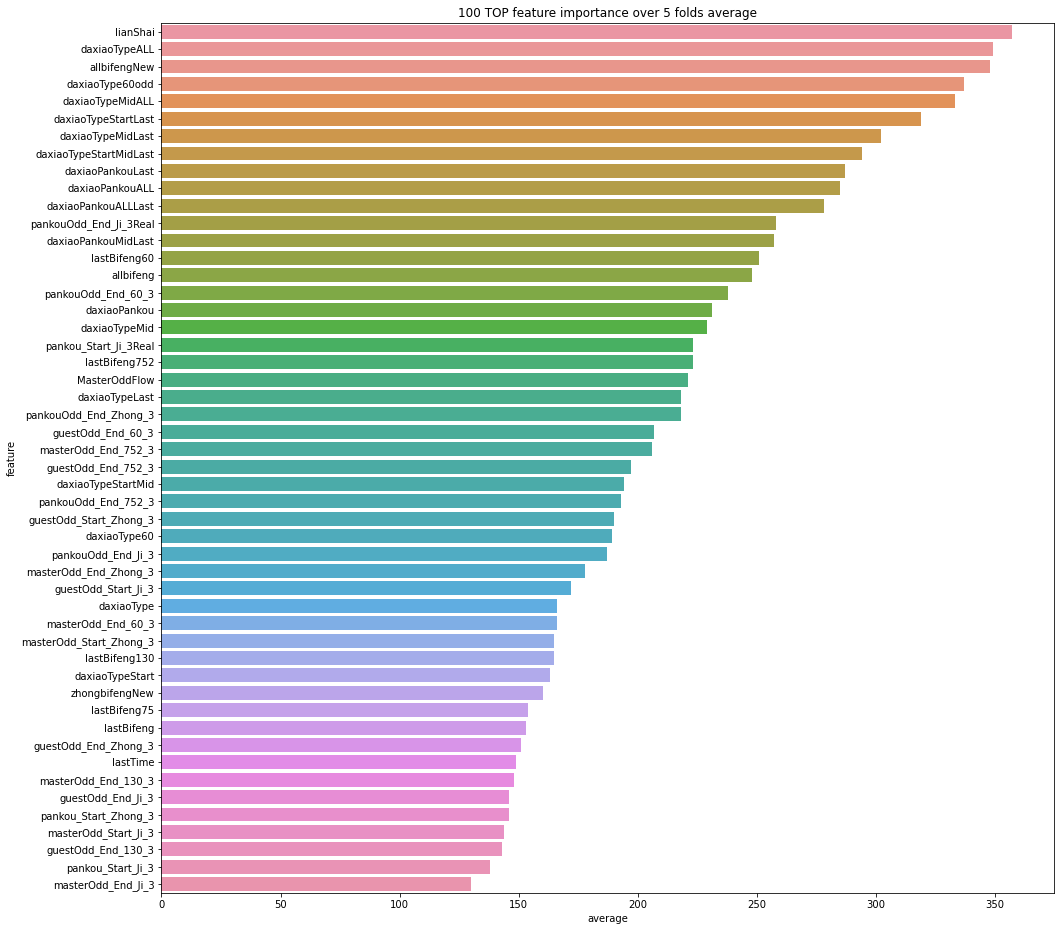

In [47]:
import seaborn as sns
feature_importance_gain=pd.DataFrame()
feature_importance_gain['feature']=columns
feature_importance_gain['fold_1']=clf.feature_importance(importance_type='gain')
feature_importance_gain['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(1)]].mean(axis=1)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importance_gain.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('100 TOP feature importance over {} folds average'.format(folds.n_splits));

In [48]:
# import seaborn as sns
# sns.set()

# import sweetviz as sv
# # 可以选择目标特征
# my_report = sv.analyze(train, target_feat ='result')
# my_report.show_html()

In [49]:
ss

NameError: name 'ss' is not defined

In [ ]:
train.info()

In [ ]:
from xgboost.sklearn import XGBClassifier
import numpy as np
c = XGBClassifier(n_estimators=100,
    max_depth=11,
    learning_rate=0.05,
    subsample=0.90,
    colsample_bytree=0.7,
    missing=-999,
    random_state=21,
    tree_method='gpu_hist',  # THE MAGICAL PARAMETER
    reg_alpha=10,
    reg_lambda=10,)
c.fit(train_x,train_y)

In [ ]:
y_preds = clf.predict(test_x)

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score

for i in [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70]:
    test_new = pd.DataFrame({'result':test_y,'predict':y_preds})
    a = test_new[test_new["predict"] >= i]
    
    def getResultA(x):
        if x >= i:
            return 1
        return 0

    a['pp'] = a['predict'].map(getResultA)
    accuracy = accuracy_score(a['result'], a['pp'])
    print(i,"accuarcy: %.2f%%" % (accuracy*100.0),a.shape[0])
    print((a.shape[0] * accuracy * 1.3) - (a.shape[0] * (1-accuracy)))

In [ ]:
test2 = test.copy(deep=True)
test2["result"] = test_y
test2['predict'] = y_preds
pred_labels = np.rint(test2['predict'])
test2["perRes"] = pred_labels
moneyList = []
for per in [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70]:
    def getResultA(x):
        if x >= per:
            return 1
        return 0
    money = 2000
    num = 0
    for i in test2[test2["predict"] >= per].to_dict(orient='records'):
        if getResultA(i["predict"]) == 1.0:
                    num += 1
                    hand = money * 0.034
                    money = money - hand
                    odd = i['masterOdd_End_752_3']
                    if i['lastTime130'] > 75:
                        odd = i['masterOdd_End_130_3']
                    odd = 1.3
                    if i["result"] == 1: 
                        money = money + hand * (odd + 1)
                    
        if money < 0:
                break
    print(money,per,num)

In [ ]:
ss

In [ ]:
data = pd.concat([train_x, train_y], axis=1)

def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['result']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle result if required
    y = data['result'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['result'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=data, shuffle=False) 

null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    
    feature_scores.append((_f, split_score, gain_score))
 
scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))
 
corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

In [ ]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats     = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    
    gain_feats     = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]

In [ ]:
col = []
for threshold in [60,70, 80 , 90, 95, 99]:
    split_feats     = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    col.append(split_feats)

for i in [0,1,2,3,4,5]:
    import lightgbm as lgb
    from sklearn.metrics import roc_auc_score,accuracy_score
    from sklearn.model_selection import StratifiedKFold
    import gc,joblib
    X = train_x[col[i]]
    y = train_y
    # del train_x,train_y
    # gc.collect()
    params = {'num_leaves': 240,  # 结果对最终效果影响较大，越大值越好，太大会出现过拟合
              'min_data_in_leaf': 30,
              'objective': 'binary',  # 定义的目标函数
              'max_depth': -1,
              'learning_rate': 0.03,
              "min_sum_hessian_in_leaf": 6,
              "boosting": "gbdt",
              "feature_fraction":  0.5992677823884304,  # 提取的特征比率
              "bagging_freq": 4,
              "bagging_fraction": 0.7100471696361973,
              "bagging_seed": 11,
              "lambda_l1": 8.545500456265467e-05,  # l1正则
              'lambda_l2': 5.985747612243422e-07,  # l2正则
              "verbosity": -1,
              "nthread": -1,  # 线程数量，-1表示全部线程，线程越多，运行的速度越快
              'metric': {'auc'},  # 评价函数选择
              "random_state": 2019,  # 随机数种子，可以防止每次运行的结果不一致
              # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
              'min_child_samples': 67
              }
    
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'n_jobs': 30,
        'learning_rate': 0.05,
        'num_leaves': 2 ** 6,
        'max_depth': 8,
        'tree_learner': 'serial',
        'colsample_bytree': 0.8,
        'subsample_freq': 1,
        'subsample': 0.8,
        'num_boost_round': 5000,
        'max_bin': 255,
        'verbose': -1,
        'seed': 2021,
        'bagging_seed': 2021,
        'feature_fraction_seed': 2021,
        'early_stopping_rounds': 100,
    }
    
    NFOLDS = 5
    folds = StratifiedKFold(n_splits=NFOLDS)

    columns = X.columns
    splits = folds.split(X, y)
    y_preds = np.zeros(test_x.shape[0])
    y_preds_train  = np.zeros(train_x.shape[0])
    score = 0

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = columns

    for fold_n, (train_index, valid_index) in enumerate(splits):
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X_valid, label=y_valid)

        clf = lgb.train(params, dtrain, 300, valid_sets=[
                        dtrain, dvalid], verbose_eval=200, early_stopping_rounds=100)

        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()

        y_pred_valid = clf.predict(X_valid)
        print(y_pred_valid)
        print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")

        score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
        y_preds += clf.predict(test_x[col[i]]) / NFOLDS

        y_pred_valid = clf.predict(X_valid)
        y_preds_train[valid_index] = y_pred_valid

        del X_train, X_valid, y_train, y_valid
        gc.collect()

    print(f"\nMean AUC = {score}")
    print(f"Out of folds AUC = {roc_auc_score(train_y, y_preds_train)}")
    from sklearn.metrics import roc_auc_score,accuracy_score

    for i in [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58]:
        test_new = pd.DataFrame({'result':test_y,'predict':y_preds})
        a = test_new[test_new["predict"] >= i]
        pred_labels = np.rint(a['predict'])
        accuracy = accuracy_score(a['result'], pred_labels)
        print(i,"accuarcy: %.2f%%" % (accuracy*100.0),a.shape[0])
        print((a.shape[0] * accuracy * 0.95) - (a.shape[0] * (1-accuracy)))
        
    test2 = test.copy(deep=True)
    test2["result"] = test_y
    test2['predict'] = y_preds
    pred_labels = np.rint(test2['predict'])
    test2["perRes"] = pred_labels
    moneyList = []
    for per in [0.451,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70]:
        def getResultA(x):
            if x >= per:
                return 1
            return 0
        money = 2000
        num = 0
        for i in test2[test2["predict"] >= per].to_dict(orient='records'):
            time = i["time"].split(" ",-1)[1]
            time = int(time.split(":",-1)[0])
            if time >= 7 and time <= 22:
                if getResultA(i["predict"]) == 1.0:
                        num += 1
                        hand = money * 0.023
                        if hand > 10000:
                            hand = 10000
                        money = money - hand
                        odd = i['masterOdd_End_752_3'] + 0.3
                        if i['lastTime130'] > 75:
                            odd = i['masterOdd_End_130_3'] + 0.3

                        if i["result"] == 1: 
                            money = money + hand * (odd + 1)
            if money < 0:
                    break
        print(money,per,num,i)

In [ ]:
train_y

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import roc_utils as ru

# Construct a binary classification problem
x, y = ru.demo_sample_data(n1=300, mu1=0.0, std1=0.5,
                           n2=300, mu2=1.0, std2=0.7)

# Compute the ROC curve...
pos_label = True
roc = ru.compute_roc(X=x, y=y, pos_label=pos_label)

# ...and visualize it
ru.plot_roc(roc, label="Sample data", color="red")
plt.show()

# To perform a ROC analysis using bootstrapping
n_samples = 20
ru.plot_roc_bootstrap(X=x, y=y, pos_label=pos_label,
                      n_bootstrap=n_samples,
                      title="Bootstrap demo");
plt.show()

In [ ]:
x, y = ru.demo_sample_data(n1=300, mu1=0.0, std1=0.5,
                           n2=300, mu2=1.0, std2=0.7)

In [ ]:
y

In [ ]:
train_y.tolist()

In [ ]:
y_preds_train

In [ ]:
from sklearn import metrics
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
#     roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

#     return list(roc_t['threshold']) 
    return roc

threshold = Find_Optimal_Cutoff(train_y,y_preds_train)

In [ ]:
threshold[threshold['threshold']>0.5]

In [ ]:
plt.plot(model_recall, model_precision, marker='.', label='Logit')
plt.plot(model_recall[43000], model_precision[43000], "ro", label="threshold")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision and Recall values for a chosen Threshold')
plt.show()

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(train_y,y_preds_train)

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

In [ ]:
optimal_threshold

In [ ]:
thresholds